# 环境和分布偏移

前面我们学习了许多机器学习的实际应用，将模型拟合各种数据集。
然而，我们从来没有想过数据最初从哪里来？以及我们计划最终如何处理模型的输出？
通常情况下，开发人员会拥有一些数据且急于开发模型，而不关注这些基本问题。

许多失败的机器学习部署（即实际应用）都可以追究到这种方式。
有时，根据测试集的精度衡量，模型表现得非常出色。
但是当数据分布突然改变时，模型在部署中会出现灾难性的失败。
更隐蔽的是，有时模型的部署本身就是扰乱数据分布的催化剂。
举一个有点荒谬却可能真实存在的例子。
假设我们训练了一个贷款申请人违约风险模型，用来预测谁将偿还贷款或违约。
这个模型发现申请人的鞋子与违约风险相关（穿牛津鞋申请人会偿还，穿运动鞋申请人会违约）。
此后，这个模型可能倾向于向所有穿着牛津鞋的申请人发放贷款，并拒绝所有穿着运动鞋的申请人。

这种情况可能会带来灾难性的后果。
首先，一旦模型开始根据鞋类做出决定，顾客就会理解并改变他们的行为。
不久，所有的申请者都会穿牛津鞋，而信用度却没有相应的提高。
总而言之，机器学习的许多应用中都存在类似的问题：
通过将基于模型的决策引入环境，我们可能会破坏模型。

虽然我们不可能在一节中讨论全部的问题，但我们希望揭示一些常见的问题，
并激发批判性思考，以便及早发现这些情况，减轻灾难性的损害。
有些解决方案很简单（要求“正确”的数据），有些在技术上很困难（实施强化学习系统），
还有一些解决方案要求我们完全跳出统计预测，解决一些棘手的、与算法伦理应用有关的哲学问题。

## 分布偏移的类型

首先，我们考虑数据分布可能发生变化的各种方式，以及为挽救模型性能可能采取的措施。
在一个经典的情景中，假设训练数据是从某个分布$p_S(\mathbf{x},y)$中采样的，
但是测试数据将包含从不同分布$p_T(\mathbf{x},y)$中抽取的未标记样本。
一个清醒的现实是：如果没有任何关于$p_S$和$p_T$之间相互关系的假设，
学习到一个分类器是不可能的。

考虑一个二元分类问题：区分狗和猫。
如果分布可以以任意方式偏移，那么我们的情景允许病态的情况，
即输入的分布保持不变：$p_S(\mathbf{x}) = p_T(\mathbf{x})$，
但标签全部翻转：$p_S(y | \mathbf{x}) = 1 - p_T(y | \mathbf{x})$。
换言之，如果将来所有的“猫”现在都是狗，而我们以前所说的“狗”现在是猫。
而此时输入$p(\mathbf{x})$的分布没有任何改变，
那么我们就不可能将这种情景与分布完全没有变化的情景区分开。

幸运的是，在对未来我们的数据可能发生变化的一些限制性假设下，
有些算法可以检测这种偏移，甚至可以动态调整，提高原始分类器的精度。

### 协变量偏移

在不同分布偏移中，协变量偏移可能是最为广泛研究的。
这里我们假设：虽然输入的分布可能随时间而改变，
但标签函数（即条件分布$P(y \mid \mathbf{x})$）没有改变。
统计学家称之为*协变量偏移*（covariate shift），
因为这个问题是由于协变量（特征）分布的变化而产生的。
虽然有时我们可以在不引用因果关系的情况下对分布偏移进行推断，
但在我们认为$\mathbf{x}$导致$y$的情况下，协变量偏移是一种自然假设。

考虑一下区分猫和狗的问题：训练数据包括猫狗的图像。

![区分猫和狗的训练数据](../assets/cat-dog-train.svg)

在测试时，我们被要求对下面的图像进行分类。

![区分猫和狗的测试数据](../assets/cat-dog-test.svg)

训练集由真实照片组成，而测试集只包含卡通图片。
假设在一个与测试集的特征有着本质不同的数据集上进行训练，
如果没有方法来适应新的领域，可能会有麻烦。

### 标签偏移

*标签偏移*（label shift）描述了与协变量偏移相反的问题。
这里我们假设标签边缘概率$P(y)$可以改变，
但是类别条件分布$P(\mathbf{x} \mid y)$在不同的领域之间保持不变。
当我们认为$y$导致$\mathbf{x}$时，标签偏移是一个合理的假设。
例如，预测患者的疾病，我们可能根据症状来判断，
即使疾病的相对流行率随着时间的推移而变化。
标签偏移在这里是恰当的假设，因为疾病会引起症状。
在另一些情况下，标签偏移和协变量偏移假设可以同时成立。
例如，当标签是确定的，即使$y$导致$\mathbf{x}$，协变量偏移假设也会得到满足。
有趣的是，在这些情况下，使用基于标签偏移假设的方法通常是有利的。
这是因为这些方法倾向于包含看起来像标签（通常是低维）的对象，
而不是像输入（通常是高维的）对象。

### 概念偏移

我们也可能会遇到*概念偏移*（concept shift）：
当标签的定义发生变化时，就会出现这种问题。
这听起来很奇怪——一只猫就是一只猫，不是吗？
然而，其他类别会随着不同时间的用法而发生变化。
精神疾病的诊断标准、所谓的时髦、以及工作头衔等等，都是概念偏移的日常映射。
事实证明，假如我们环游美国，根据所在的地理位置改变我们的数据来源，
我们会发现关于“软饮”名称的分布发生了相当大的概念偏移，
如下图所示。

![美国软饮名称的概念偏移](../assets/popvssoda.png)
:width:`400px`

如果我们要建立一个机器翻译系统，
$P(y \mid \mathbf{x})$的分布可能会因我们的位置不同而得到不同的翻译。
这个问题可能很难被发现。
所以，我们最好可以利用在时间或空间上逐渐发生偏移的知识。

## 分布偏移示例

在深入研究形式体系和算法之前，我们可以讨论一些协变量偏移或概念偏移可能并不明显的具体情况。

### 医学诊断

假设我们想设计一个检测癌症的算法，从健康人和病人那里收集数据，然后训练算法。
它工作得很好，有很高的精度，然后我们得出了已经准备好在医疗诊断上取得成功的结论。
请先别着急。

收集训练数据的分布和在实际中遇到的数据分布可能有很大的不同。
这件事在一个不幸的初创公司身上发生过，我们中的一些作者几年前和他们合作过。
他们正在研究一种血液检测方法，主要针对一种影响老年男性的疾病，
并希望利用他们从病人身上采集的血液样本进行研究。
然而，从健康男性身上获取血样比从系统中已有的病人身上获取要困难得多。
作为补偿，这家初创公司向一所大学校园内的学生征集献血，作为开发测试的健康对照样本。
然后这家初创公司问我们是否可以帮助他们建立一个用于检测疾病的分类器。

正如我们向他们解释的那样，用近乎完美的精度来区分健康和患病人群确实很容易。
然而，这可能是因为受试者在年龄、激素水平、体力活动、
饮食、饮酒以及其他许多与疾病无关的因素上存在差异。
这对检测疾病的分类器可能并不适用。
这些抽样可能会遇到极端的协变量偏移。
此外，这种情况不太可能通过常规方法加以纠正。
简言之，他们浪费了一大笔钱。

### 自动驾驶汽车

对于一家想利用机器学习来开发自动驾驶汽车的公司，一个关键部件是“路沿检测器”。
由于真实的注释数据获取成本很高，他们想出了一个“聪明”的想法：
将游戏渲染引擎中的合成数据用作额外的训练数据。
这对从渲染引擎中抽取的“测试数据”非常有效，但应用在一辆真正的汽车里真是一场灾难。
正如事实证明的那样，路沿被渲染成一种非常简单的纹理。
更重要的是，所有的路沿都被渲染成了相同的纹理，路沿检测器很快就学习到了这个“特征”。

当美军第一次试图在森林中探测坦克时，也发生了类似的事情。
他们在没有坦克的情况下拍摄了森林的航拍照片，然后把坦克开进森林，拍摄了另一组照片。
使用这两组数据训练的分类器似乎工作得很好。
不幸的是，分类器仅仅学会了如何区分有阴影的树和没有阴影的树：
第一组照片是在清晨拍摄的，而第二组是在中午拍摄的。

### 非平稳分布

当分布变化缓慢并且模型没有得到充分更新时，就会出现更微妙的情况：
*非平稳分布*（nonstationary distribution）。
以下是一些典型例子：

* 训练一个计算广告模型，但却没有经常更新（例如，一个2009年训练的模型不知道一个叫iPad的不知名新设备刚刚上市）；
* 建立一个垃圾邮件过滤器，它能很好地检测到所有垃圾邮件。但是，垃圾邮件发送者们变得聪明起来，制造出新的信息，看起来不像我们以前见过的任何垃圾邮件；
* 建立一个产品推荐系统，它在整个冬天都有效，但圣诞节过后很久还会继续推荐圣诞帽。

### 更多轶事

* 建立一个人脸检测器，它在所有基准测试中都能很好地工作，但是它在测试数据上失败了：有问题的例子是人脸充满了整个图像的特写镜头（训练集中没有这样的数据）。
* 为美国市场建立了一个网络搜索引擎，并希望将其部署到英国。
* 通过在一个大的数据集来训练图像分类器，其中每一个大类的数量在数据集近乎是平均的，比如1000个类别，每个类别由1000个图像表示。但是将该系统部署到真实世界中，照片的实际标签分布显然是不均匀的。

## 分布偏移纠正

正如我们所讨论的，在许多情况下训练和测试分布$P(\mathbf{x}, y)$是不同的。
在一些情况下，我们很幸运，不管协变量、标签或概念如何发生偏移，模型都能正常工作。
在另一些情况下，我们可以通过运用策略来应对这种偏移，从而做得更好。
本节的其余部分将着重于应对这种偏移的技术细节。

### 经验风险与实际风险

首先我们反思一下在模型训练期间到底发生了什么？
训练数据$\{(\mathbf{x}_1, y_1), \ldots, (\mathbf{x}_n, y_n)\}$
的特征和相关的标签经过迭代，在每一个小批量之后更新模型$f$的参数。
为了简单起见，我们不考虑正则化，因此极大地降低了训练损失：

$$\mathop{\mathrm{minimize}}_f \frac{1}{n} \sum_{i=1}^n l(f(\mathbf{x}_i), y_i),$$
:eqlabel:`eq_empirical-risk-min`

其中$l$是损失函数，用来度量：
给定标签$y_i$，预测$f(\mathbf{x}_i)$的“糟糕程度”。
统计学家称 :eqref:`eq_empirical-risk-min`中的这一项为经验风险。
*经验风险*（empirical risk）是为了近似 *真实风险*（true risk），
整个训练数据上的平均损失，即从其真实分布$p(\mathbf{x},y)$中
抽取的所有数据的总体损失的期望值：

$$E_{p(\mathbf{x}, y)} [l(f(\mathbf{x}), y)] = \int\int l(f(\mathbf{x}), y) p(\mathbf{x}, y) \;d\mathbf{x}dy.$$
:eqlabel:`eq_true-risk`

然而在实践中，我们通常无法获得总体数据。
因此，*经验风险最小化*即在 :eqref:`eq_empirical-risk-min`中最小化经验风险，
是一种实用的机器学习策略，希望能近似最小化真实风险。

### 协变量偏移纠正

假设对于带标签的数据$(\mathbf{x}_i, y_i)$，
我们要评估$P(y \mid \mathbf{x})$。
然而观测值$\mathbf{x}_i$是从某些*源分布*$q(\mathbf{x})$中得出的，
而不是从*目标分布*$p(\mathbf{x})$中得出的。
幸运的是，依赖性假设意味着条件分布保持不变，即：
$p(y \mid \mathbf{x}) = q(y \mid \mathbf{x})$。
如果源分布$q(\mathbf{x})$是“错误的”，
我们可以通过在真实风险的计算中，使用以下简单的恒等式来进行纠正：

$$
\begin{aligned}
\int\int l(f(\mathbf{x}), y) p(y \mid \mathbf{x})p(\mathbf{x}) \;d\mathbf{x}dy =
\int\int l(f(\mathbf{x}), y) q(y \mid \mathbf{x})q(\mathbf{x})\frac{p(\mathbf{x})}{q(\mathbf{x})} \;d\mathbf{x}dy.
\end{aligned}
$$

换句话说，我们需要根据数据来自正确分布与来自错误分布的概率之比，
来重新衡量每个数据样本的权重：

$$\beta_i \stackrel{\mathrm{def}}{=} \frac{p(\mathbf{x}_i)}{q(\mathbf{x}_i)}.$$

将权重$\beta_i$代入到每个数据样本$(\mathbf{x}_i, y_i)$中，
我们可以使用”加权经验风险最小化“来训练模型：

$$\mathop{\mathrm{minimize}}_f \frac{1}{n} \sum_{i=1}^n \beta_i l(f(\mathbf{x}_i), y_i).$$
:eqlabel:`eq_weighted-empirical-risk-min`

由于不知道这个比率，我们需要估计它。
有许多方法都可以用，包括一些花哨的算子理论方法，
试图直接使用最小范数或最大熵原理重新校准期望算子。
对于任意一种这样的方法，我们都需要从两个分布中抽取样本：
“真实”的分布$p$，通过访问测试数据获取；
训练集$q$，通过人工合成的很容易获得。
请注意，我们只需要特征$\mathbf{x} \sim p(\mathbf{x})$，
不需要访问标签$y \sim p(y)$。

在这种情况下，有一种非常有效的方法可以得到几乎与原始方法一样好的结果：
*对数几率回归*（logistic regression）。
这是用于二元分类的[softmax回归](https://github.com/lixinjie97/Deep_learning_tutorial/blob/main/02.linear-networks/04.softmax-regression.ipynb)的一个特例。
综上所述，我们学习了一个分类器来区分从$p(\mathbf{x})$抽取的数据
和从$q(\mathbf{x})$抽取的数据。
如果无法区分这两个分布，则意味着相关的样本可能来自这两个分布中的任何一个。
另一方面，任何可以很好区分的样本都应该相应地显著增加或减少权重。

为了简单起见，假设我们分别从$p(\mathbf{x})$和$q(\mathbf{x})$
两个分布中抽取相同数量的样本。
现在用$z$标签表示：从$p$抽取的数据为$1$，从$q$抽取的数据为$-1$。
然后，混合数据集中的概率由下式给出

$$P(z=1 \mid \mathbf{x}) = \frac{p(\mathbf{x})}{p(\mathbf{x})+q(\mathbf{x})} \text{ and hence } \frac{P(z=1 \mid \mathbf{x})}{P(z=-1 \mid \mathbf{x})} = \frac{p(\mathbf{x})}{q(\mathbf{x})}.$$

因此，如果我们使用对数几率回归方法，其中
$P(z=1 \mid \mathbf{x})=\frac{1}{1+\exp(-h(\mathbf{x}))}$
（$h$是一个参数化函数），则很自然有：

$$
\beta_i = \frac{1/(1 + \exp(-h(\mathbf{x}_i)))}{\exp(-h(\mathbf{x}_i))/(1 + \exp(-h(\mathbf{x}_i)))} = \exp(h(\mathbf{x}_i)).
$$

因此，我们需要解决两个问题：
第一个问题是关于区分来自两个分布的数据；
第二个问题是关于 :eqref:`eq_weighted-empirical-risk-min`
中的加权经验风险的最小化问题。
在这个问题中，我们将对其中的项加权$\beta_i$。

现在，我们来看一下完整的协变量偏移纠正算法。
假设我们有一个训练集$\{(\mathbf{x}_1, y_1), \ldots, (\mathbf{x}_n, y_n)\}$
和一个未标记的测试集$\{\mathbf{u}_1, \ldots, \mathbf{u}_m\}$。
对于协变量偏移，我们假设$1 \leq i \leq n$的$\mathbf{x}_i$来自某个源分布，
$\mathbf{u}_i$来自目标分布。
以下是纠正协变量偏移的典型算法：

1. 生成一个二元分类训练集：$\{(\mathbf{x}_1, -1), \ldots, (\mathbf{x}_n, -1), (\mathbf{u}_1, 1), \ldots, (\mathbf{u}_m, 1)\}$。
1. 用对数几率回归训练二元分类器得到函数$h$。
1. 使用$\beta_i = \exp(h(\mathbf{x}_i))$或更好的$\beta_i = \min(\exp(h(\mathbf{x}_i)), c)$（$c$为常量）对训练数据进行加权。
1. 使用权重$\beta_i$进行 :eqref:`eq_weighted-empirical-risk-min` 中$\{(\mathbf{x}_1, y_1), \ldots, (\mathbf{x}_n, y_n)\}$的训练。

请注意，上述算法依赖于一个重要的假设：
需要目标分布(例如，测试分布)中的每个数据样本在训练时出现的概率非零。
如果我们找到$p(\mathbf{x}) > 0$但$q(\mathbf{x}) = 0$的点，
那么相应的重要性权重会是无穷大。

### 标签偏移纠正

假设我们处理的是$k$个类别的分类任务。
使用之前章节中相同符号，
$q$和$p$中分别是源分布（例如训练时的分布）和目标分布（例如测试时的分布）。
假设标签的分布随时间变化：$q(y) \neq p(y)$，
但类别条件分布保持不变：$q(\mathbf{x} \mid y)=p(\mathbf{x} \mid y)$。
如果源分布$q(y)$是“错误的”，
我们可以根据 :eqref:`eq_true-risk`中定义的真实风险中的恒等式进行更正：

$$
\begin{aligned}
\int\int l(f(\mathbf{x}), y) p(\mathbf{x} \mid y)p(y) \;d\mathbf{x}dy =
\int\int l(f(\mathbf{x}), y) q(\mathbf{x} \mid y)q(y)\frac{p(y)}{q(y)} \;d\mathbf{x}dy.
\end{aligned}
$$

这里，重要性权重将对应于标签似然比率

$$\beta_i \stackrel{\mathrm{def}}{=} \frac{p(y_i)}{q(y_i)}.$$

标签偏移的一个好处是，如果我们在源分布上有一个相当好的模型，
那么我们可以得到对这些权重的一致估计，而不需要处理周边的其他维度。
在深度学习中，输入往往是高维对象（如图像），而标签通常是低维（如类别）。

为了估计目标标签分布，我们首先采用性能相当好的现成的分类器（通常基于训练数据进行训练），
并使用验证集（也来自训练分布）计算其混淆矩阵。
混淆矩阵$\mathbf{C}$是一个$k \times k$矩阵，
其中每列对应于标签类别，每行对应于模型的预测类别。
每个单元格的值$c_{ij}$是验证集中，真实标签为$j$，
而我们的模型预测为$i$的样本数量所占的比例。

现在，我们不能直接计算目标数据上的混淆矩阵，
因为我们无法看到真实环境下的样本的标签，
除非我们再搭建一个复杂的实时标注流程。
然而，我们所能做的是将所有模型在测试时的预测取平均数，
得到平均模型输出$\mu(\hat{\mathbf{y}}) \in \mathbb{R}^k$，
其中第$i$个元素$\mu(\hat{y}_i)$是我们模型预测测试集中$i$的总预测分数。

结果表明，如果我们的分类器一开始就相当准确，
并且目标数据只包含我们以前见过的类别，
以及如果标签偏移假设成立（这里最强的假设），
我们就可以通过求解一个简单的线性系统来估计测试集的标签分布

$$\mathbf{C} p(\mathbf{y}) = \mu(\hat{\mathbf{y}}),$$

因为作为一个估计，$\sum_{j=1}^k c_{ij} p(y_j) = \mu(\hat{y}_i)$
对所有$1 \leq i \leq k$成立，
其中$p(y_j)$是$k$维标签分布向量$p(\mathbf{y})$的第$j^\mathrm{th}$元素。
如果我们的分类器一开始就足够精确，那么混淆矩阵$\mathbf{C}$将是可逆的，
进而我们可以得到一个解$p(\mathbf{y}) = \mathbf{C}^{-1} \mu(\hat{\mathbf{y}})$。

因为我们观测源数据上的标签，所以很容易估计分布$q(y)$。
那么对于标签为$y_i$的任何训练样本$i$，
我们可以使用我们估计的$p(y_i)/q(y_i)$比率来计算权重$\beta_i$，
并将其代入 :eqref:`eq_weighted-empirical-risk-min`中的加权经验风险最小化中。

### 概念偏移纠正

概念偏移很难用原则性的方式解决。
例如，在一个问题突然从“区分猫和狗”偏移为“区分白色和黑色动物”的情况下，
除了从零开始收集新标签和训练，别无妙方。
幸运的是，在实践中这种极端的偏移是罕见的。
相反，通常情况下，概念的变化总是缓慢的。
比如下面是一些例子：

* 在计算广告中，新产品推出后，旧产品变得不那么受欢迎了。这意味着广告的分布和受欢迎程度是逐渐变化的，任何点击率预测器都需要随之逐渐变化；
* 由于环境的磨损，交通摄像头的镜头会逐渐退化，影响摄像头的图像质量；
* 新闻内容逐渐变化（即新新闻的出现）。

在这种情况下，我们可以使用与训练网络相同的方法，使其适应数据的变化。
换言之，我们使用新数据更新现有的网络权重，而不是从头开始训练。

### 批量学习

在*批量学习*（batch learning）中，我们可以访问一组训练特征和标签
$\{(\mathbf{x}_1, y_1), \ldots, (\mathbf{x}_n, y_n)\}$，
我们使用这些特性和标签训练$f(\mathbf{x})$。
然后，我们部署此模型来对来自同一分布的新数据$(\mathbf{x}, y)$进行评分。
例如，我们可以根据猫和狗的大量图片训练猫检测器。
一旦我们训练了它，我们就把它作为智能猫门计算视觉系统的一部分，来控制只允许猫进入。
然后这个系统会被安装在客户家中，基本再也不会更新。

### 在线学习

除了“批量”地学习，我们还可以单个“在线”学习数据$(\mathbf{x}_i, y_i)$。
更具体地说，我们首先观测到$\mathbf{x}_i$，
然后我们得出一个估计值$f(\mathbf{x}_i)$，
只有当我们做到这一点后，我们才观测到$y_i$。
然后根据我们的决定，我们会得到奖励或损失。
许多实际问题都属于这一类。
例如，我们需要预测明天的股票价格，
这样我们就可以根据这个预测进行交易。
在一天结束时，我们会评估我们的预测是否盈利。
换句话说，在*在线学习*（online learning）中，我们有以下的循环。
在这个循环中，给定新的观测结果，我们会不断地改进我们的模型。

$$
\mathrm{model} ~ f_t \longrightarrow
\mathrm{data} ~ \mathbf{x}_t \longrightarrow
\mathrm{estimate} ~ f_t(\mathbf{x}_t) \longrightarrow
\mathrm{observation} ~ y_t \longrightarrow
\mathrm{loss} ~ l(y_t, f_t(\mathbf{x}_t)) \longrightarrow
\mathrm{model} ~ f_{t+1}
$$

### 老虎机

*老虎机*（bandits）是上述问题的一个特例。
虽然在大多数学习问题中，我们有一个连续参数化的函数$f$（例如，一个深度网络）。
但在一个*老虎机*问题中，我们只有有限数量的手臂可以拉动。
也就是说，我们可以采取的行动是有限的。
对于这个更简单的问题，可以获得更强的最优性理论保证，这并不令人惊讶。
我们之所以列出它，主要是因为这个问题经常被视为一个单独的学习问题的情景。

### 控制

在很多情况下，环境会记住我们所做的事。
不一定是以一种对抗的方式，但它会记住，而且它的反应将取决于之前发生的事情。
例如，咖啡锅炉控制器将根据之前是否加热锅炉来观测到不同的温度。
在这种情况下，PID（比例—积分—微分）控制器算法是一个流行的选择。
同样，一个用户在新闻网站上的行为将取决于之前向她展示的内容（例如，大多数新闻她只阅读一次）。
许多这样的算法形成了一个环境模型，在这个模型中，他们的行为使得他们的决策看起来不那么随机。
近年来，控制理论（如PID的变体）也被用于自动调整超参数，
以获得更好的解构和重建质量，提高生成文本的多样性和生成图像的重建质量
:cite:`Shao.Yao.Sun.ea.2020`。

### 强化学习

*强化学习*（reinforcement learning）强调如何基于环境而行动，以取得最大化的预期利益。
国际象棋、围棋、西洋双陆棋或星际争霸都是强化学习的应用实例。
再比如，为自动驾驶汽车制造一个控制器，或者以其他方式对自动驾驶汽车的驾驶方式做出反应
（例如，试图避开某物体，试图造成事故，或者试图与其合作）。

### 考虑到环境

上述不同情况之间的一个关键区别是：
在静止环境中可能一直有效的相同策略，
在环境能够改变的情况下可能不会始终有效。
例如，一个交易者发现的套利机会很可能在他开始利用它时就消失了。
环境变化的速度和方式在很大程度上决定了我们可以采用的算法类型。
例如，如果我们知道事情只会缓慢地变化，
就可以迫使任何估计也只能缓慢地发生改变。
如果我们知道环境可能会瞬间发生变化，但这种变化非常罕见，
我们就可以在使用算法时考虑到这一点。
当一个数据科学家试图解决的问题会随着时间的推移而发生变化时，
这些类型的知识至关重要。

## 机器学习中的公平、责任和透明度

最后，重要的是，当我们部署机器学习系统时，
不仅仅是在优化一个预测模型，
而通常是在提供一个会被用来（部分或完全）进行自动化决策的工具。
这些技术系统可能会通过其进行的决定而影响到每个人的生活。

从考虑预测到决策的飞跃不仅提出了新的技术问题，
而且还提出了一系列必须仔细考虑的伦理问题。
如果我们正在部署一个医疗诊断系统，我们需要知道它可能适用于哪些人群，哪些人群可能无效。
忽视对一个亚群体的幸福的可预见风险可能会导致我们执行劣质的护理水平。
此外，一旦我们规划整个决策系统，我们必须退后一步，重新考虑如何评估我们的技术。
在这个视野变化所导致的结果中，我们会发现精度很少成为合适的衡量标准。
例如，当我们将预测转化为行动时，我们通常会考虑到各种方式犯错的潜在成本敏感性。
举个例子：将图像错误地分到某一类别可能被视为种族歧视，而错误地分到另一个类别是无害的，
那么我们可能需要相应地调整我们的阈值，在设计决策方式时考虑到这些社会价值。
我们还需要注意预测系统如何导致反馈循环。
例如，考虑预测性警务系统，它将巡逻人员分配到预测犯罪率较高的地区。
很容易看出一种令人担忧的模式是如何出现的：

 1. 犯罪率高的社区会得到更多的巡逻；
 2. 因此，在这些社区中会发现更多的犯罪行为，输入可用于未来迭代的训练数据；
 3. 面对更多的积极因素，该模型预测这些社区还会有更多的犯罪；
 4. 下一次迭代中，更新后的模型会更加倾向于针对同一个地区，这会导致更多的犯罪行为被发现等等。

通常，在建模纠正过程中，模型的预测与训练数据耦合的各种机制都没有得到解释，
研究人员称之为“失控反馈循环”的现象。
此外，我们首先要注意我们是否解决了正确的问题。
比如，预测算法现在在信息传播中起着巨大的中介作用，
个人看到的新闻应该由他们喜欢的Facebook页面决定吗？
这些只是在机器学习职业生涯中可能遇到的令人感到“压力山大”的道德困境中的一小部分。

## 小结

* 在许多情况下，训练集和测试集并不来自同一个分布。这就是所谓的分布偏移。
* 真实风险是从真实分布中抽取的所有数据的总体损失的预期。然而，这个数据总体通常是无法获得的。经验风险是训练数据的平均损失，用于近似真实风险。在实践中，我们进行经验风险最小化。
* 在相应的假设条件下，可以在测试时检测并纠正协变量偏移和标签偏移。在测试时，不考虑这种偏移可能会成为问题。
* 在某些情况下，环境可能会记住自动操作并以令人惊讶的方式做出响应。在构建模型时，我们必须考虑到这种可能性，并继续监控实时系统，并对我们的模型和环境以意想不到的方式纠缠在一起的可能性持开放态度。

## 练习

1. 当我们改变搜索引擎的行为时会发生什么？用户可能会做什么？广告商呢？
2. 实现一个协变量偏移检测器。提示：构建一个分类器。
3. 实现协变量偏移纠正。
4. 除了分布偏移，还有什么会影响经验风险接近真实风险的程度？

### 练习一

1.当我们改变搜索引擎的行为时会发生什么？用户可能会做什么？广告商呢？

&emsp;&emsp;当改变搜索引擎的行为时，可能会发生一下情况：



1. 用户的反应：用户可能会对搜索引擎行为的改变做出不同的反应。一些用户可能会适应并接受这些变化，继续使用搜索引擎进行他们的查询。其他用户可能会感到不满意或困惑，因为他们习惯了特定的搜索结果和功能。这可能导致他们寻找替代的搜索引擎或采取其他方式来获取所需信息。

2. 用户行为的变化：如果搜索引擎的行为发生显著变化，用户可能会调整他们的搜索策略。他们可能会更改搜索关键词的选择、尝试不同的搜索策略或使用高级搜索选项来获得更精确的结果。一些用户可能会更多地依赖其他信息来源，如社交媒体、专业网站或应用程序。

3. 广告商的反应：搜索引擎行为的改变可能会对广告商产生影响。广告商通常依赖搜索引擎为他们的广告投放提供曝光和流量。如果搜索引擎的行为发生变化，广告商可能需要重新评估他们的广告策略和投放方式，以确保他们的广告仍然能够有效地触达目标受众。

4. 广告排名和竞争：搜索引擎行为的改变可能会对广告排名和竞争产生影响。如果搜索引擎调整了广告排名算法或显示广告的方式，广告商可能需要重新评估他们的广告优化策略和预算分配，以适应这些变化。竞争激烈的行业可能会看到广告竞价的变化和竞争格局的调整。

&emsp;&emsp;需要注意的是，具体情况会根据搜索引擎的改变方式、用户群体和广告市场的特点而有所不同。搜索引擎的行为改变可能是出于改善搜索结果的质量、提供更相关的问题或应对不断变化的用户需求等目的。

### 练习二

2.实现一个协变量偏移检测器。提示：构建一个分类器。

&emsp;&emsp;为了构造协变量偏移的场景我们使用[kaggle的dogvscat训练数据集](https://www.kaggle.com/competitions/dogs-vs-cats/data?select=train.zip)选取一部分动漫化处理(处理方法见这个[地址](https://github.com/bryandlee/animegan2-pytorch))，然后构成一个cartoonvsnormal数据集(数据集 百度网盘链接：https://pan.baidu.com/s/1FvWaa3MBxQXLEmOLZTm6uw?pwd=1234 存放在../data/下)，用已经预训练好resnet50模型加一个全连接层(这部分会在会面的章节学到，你可以把这部分认为是本章提到的exp(h(x))的h函数)来实现分类器的效果。
resnet50参考：https://pytorch.org/vision/main/models/generated/torchvision.models.resnet50.html

&emsp;&emsp;要分类的数据集(不过值得一提的是我找到的卡通化方法不是非常有效，一些图片没有很好实现卡通化的效果，不过还是足够作为协变量偏移的例子来学习)
![](../assets/dog-cat-cartoon.png)

In [1]:
import torch
import torchvision
from torchvision import datasets, models, transforms
import os
from torch.autograd import Variable
import torch.nn as nn
import torch.utils.data
import torch.nn.functional as F
from d2l import torch as d2l
import gc
import random

In [2]:
gc.collect() # 清理内存
# 计算数据标准差和平均值的函数

def getmean_str(data_dir, name):
    # 对图片进行一些变化操作
    data_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])
    # 构建图片数据集
    image_datasets = datasets.ImageFolder(root=data_dir,
                                         transform=data_transforms)
    data_loader = torch.utils.data.DataLoader(
        image_datasets, batch_size=1, shuffle=False, num_workers=0
    )
    # 计算数据平均值和标准差
    mean = torch.zeros(3)
    std = torch.zeros(3)
    for X, _ in data_loader:
        for d in range(3):
            mean[d] += X[:, d, :, :].mean()
            std[d] += X[:, d, :, :].std()
    mean.div_(len(image_datasets))
    std.div_(len(image_datasets))
    print(name, " mean:", mean, "std:", std)
    return list(mean.numpy()), list(std.numpy()) # 返回平均值和标准差

# 加载数据函数
def load_data_cartoonvsnormal(data_dir, meanlist, stdlist, batch_size=32):
    data_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(meanlist, stdlist),
    ])
    # 拼接路径
    image_datasets = datasets.ImageFolder(root=data_dir,
                                         transform=data_transforms)
    # 数据加载器
    data_iter = torch.utils.data.DataLoader(image_datasets, batch_size=batch_size, shuffle=True)
    return (data_iter, image_datasets)

# 训练函数
def train_epoch_ch4_9(net, train_iter, loss, updater, Use_gpu,detector=None): 
    train_acc=0.0
    train_loss=0.0
    for batch,data in enumerate(train_iter,1):
            X,y = data
            if Use_gpu:
                X,y = Variable(X.cuda()),Variable(y.cuda())
            else:
                X,y = Variable(X),Variable(y)
            y_hat = net(X)
            if detector!=None:
                
                beta= detector(X.detach())
                if Use_gpu:
                    beta=Variable(beta.cuda())
            optimizer.zero_grad()
            l = loss(y_hat,y) if detector==None else loss(y_hat,y,beta)
            l.backward()#反向传播
            optimizer.step()#优化
            _,pred =torch.max(y_hat,1)
            train_acc += torch.sum(pred == y)
            train_loss += l.item()
            
            if batch%200 == 0 :
                print("Batch:{},Train Loss:{:.4f},Train ACC:{:.4f}%".format(batch,train_loss/batch,100*train_acc/(y.numel()*batch)))
    return (train_loss/(len(train_iter))),(train_acc/((batch_size)*len(train_iter))).cpu().numpy()
# 评价函数
def evaluate_accuracy_ch4_9(net, data_iter, Use_gpu):
    if Use_gpu:
        net = net.cuda()
    net.eval() # 将模型设置为评估模式
    test_acc = 0.0
    number = 0.0
    with torch.no_grad():
        for data in data_iter:
            X, y = data
            if Use_gpu: # 有gpu在gpu下评估
                X, y = Variable(X.cuda()), Variable(y.cuda())
            else:
                X, y = Variable(X), Variable(y)
            y_pred = net(X)
            _, pred = torch.max(y_pred, 1)
            test_acc += torch.sum(pred == y)
            number += y.numel()
        test_acc = ((test_acc / number).cpu().numpy())
    return test_acc
# 训练函数
def train_ch4_9(net, train_iter, test_iter, loss, num_epochs, updater,Use_gpu,test_iter2=None,savename='../data/ch04-4-9-2and4-9-3/covariate_shift_detectormodel.pth',detector=None): 
    if test_iter2==None:
        animator = d2l.Animator(xlabel='epoch',ylabel='Y', xlim=[1, num_epochs],
                        legend=['train loss', 'train acc', 'test acc'])
    else:
        animator = d2l.Animator(xlabel='epoch',ylabel='Y', xlim=[1, num_epochs],
                        legend=['train loss', 'train acc', 'test cartoon acc','test normal acc '])
        
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch4_9(net, train_iter, loss, updater,Use_gpu,detector)
        test_acc = evaluate_accuracy_ch4_9(net, test_iter,Use_gpu)
        if test_iter2!=None:
            test_acc2 = evaluate_accuracy_ch4_9(net, test_iter2,Use_gpu)
            animator.add(epoch + 1, train_metrics + (test_acc,test_acc2,))
            print("epoch{} Loss:{:.4f} Train Acc:{:.4f}% Test Cartoon Acc:{:.4f}% Test Normal Acc:{:.4f}%".format(epoch+1, train_metrics[0], 100*train_metrics[1],100*test_acc,100*test_acc2))
        else:
            animator.add(epoch + 1, train_metrics + (test_acc,))
            print("epoch{} Loss:{:.4f} Train Acc:{:.4f}% Test  Acc:{:.4f}%".format(epoch+1, train_metrics[0], 100*train_metrics[1],100*test_acc))
    
    train_loss, train_acc = train_metrics
   
    torch.save(net.state_dict(),savename)

    torch.cuda.empty_cache()
    print("save",savename,"over")
    
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

epoch15 Loss:0.1890 Train Acc:95.6450% Test  Acc:95.5400%
save ../data/ch04-4-9-2and4-9-3/covariate_shift_detectormodel.pth over


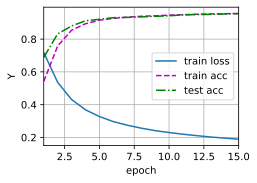

In [3]:
#数据加载

batch_size=32
data_dir = "../data/ch04-4-9-2and4-9-3/cartoonvsnormal"
#计算平均值和标准差
mean_train_list,std_train_list=getmean_str(os.path.join(data_dir, 'train'),'train')
mean_test_list,std_test_list=getmean_str(os.path.join(data_dir, 'test'),'test')
#计算cartoon集和normal集大小
cartoon_num=1.0*(len(os.listdir(os.path.join(data_dir, 'train','cartoon')))+len(os.listdir(os.path.join(data_dir, 'test','cartoon'))))
normal_num=1.0*(len(os.listdir(os.path.join(data_dir, 'train','normal')))+len(os.listdir(os.path.join(data_dir, 'test','normal'))))
#加载数据集
train_iter,image_train_datasets=load_data_cartoonvsnormal(os.path.join(data_dir, 'train'),mean_train_list,std_train_list,batch_size)
test_iter,image_test_datasets=load_data_cartoonvsnormal(os.path.join(data_dir, 'test'),mean_test_list,std_test_list,batch_size)
index_classes = list(image_test_datasets.class_to_idx.keys())
print("类别一 {}，数量{}，类别二 {} 数量{}".format(index_classes[0],cartoon_num,index_classes[1],normal_num))
print("类别一 {}，数量{}，类别二 {} 数量{}".format(index_classes[0],cartoon_num,index_classes[1],normal_num))
#加载模型
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
Use_gpu = torch.cuda.is_available()#检测有无gpu

for parma in model.parameters():
    parma.requires_grad = False#屏蔽预训练模型的权重，只训练最后一层的全连接的权重
model.fc = torch.nn.Linear(2048,2)
nn.init.xavier_uniform_(model.fc.weight)

#是否使用gpu
if Use_gpu:
    model = model.cuda()

#损失函数和优化器
weight=torch.tensor([normal_num,cartoon_num])
weight=weight.cuda() if Use_gpu else weight
loss_f = torch.nn.CrossEntropyLoss(weight=weight)#不同类别数据量不同 添加权重来平衡
optimizer = torch.optim.SGD(model.fc.parameters(),lr = 1e-4)

num_epochs = 15
train_ch4_9(model, train_iter, test_iter, loss_f, num_epochs,optimizer,Use_gpu)
#清除内存
del model
torch.cuda.empty_cache()

In [4]:
def covariate_shift_detector(input_image,model_pth='../data/ch04-4-9-2and4-9-3/covariate_shift_detectormodel.pth'):
    softmax=nn.Softmax(dim = 1)
    Use_gpu = torch.cuda.is_available()
    model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
    model.fc = torch.nn.Linear(2048,2)
    model.load_state_dict(torch.load(model_pth))
    if Use_gpu:
        model = model.cuda()
    model.eval()
    beta=lambda x:min(x[0][0]/x[0][1],1.0)
    with torch.no_grad():
        if len(input_image)==1:
            output=beta(softmax(model(input_image)))
            
        else:
            output=torch.tensor(list(map(lambda x: beta(softmax(model(torch.unsqueeze(x,0)))),input_image )))
        del model
        torch.cuda.empty_cache()
        return output

In [5]:
#随机重取一个测试数据看看网络分类情况

testnum=random.randint(0,len(image_test_datasets)-1)
index_classes = list(image_test_datasets.class_to_idx.keys())
input_image=torch.unsqueeze(image_test_datasets[testnum][0],0)
if torch.cuda.is_available():
    input_image=input_image.cuda()
output=index_classes[0] if covariate_shift_detector(input_image)>=1 else index_classes[1]
print("testnum ",testnum," 推断类别：",output,"实际类别：",index_classes[image_test_datasets[testnum][1]])
del input_image

testnum  424  推断类别： cartoon 实际类别： cartoon


In [6]:
gc.collect()#释放内存
Use_gpu = torch.cuda.is_available()
#是否使用gpu
if Use_gpu:
    torch.cuda.empty_cache()
    print('clear')
input_image=[i[0].cuda() for i in image_test_datasets] if torch.cuda.is_available() else [i[0] for i in image_test_datasets]
output=covariate_shift_detector(input_image)
test_label=torch.tensor([i[1] for i in image_test_datasets])
cartoonacc=torch.tensor(list(map(lambda x: 1 if x >=1 else 0 ,output-torch.mul(output,test_label)))).sum()/(len(test_label)-test_label.sum())
normalacc=torch.tensor(list(map(lambda x: 1 if 0<x < 1 else 0 ,torch.mul(output,test_label)))).sum()/(test_label.sum())
print('卡通图片预测正确率:{:.4f}% ,正常图片预测正确率:{:.4f}%'.format(100*cartoonacc,100*normalacc))
del input_image

clear
卡通图片预测正确率:92.0000% ,正常图片预测正确率:96.4250%


#### 练习三

3.实现协变量偏移纠正。

&emsp;&emsp;首先展示没有使用分类器来训练模型的结果，可以看出训练的后期，即使各个数据曲线已经趋平，训练准确率任然高于测试准确率。

epoch10 Loss:0.1262 Train Acc:97.1900% Test Cartoon Acc:89.1800% Test Normal Acc:97.4000%
save ../data/ch04-4-9-2and4-9-3/dogvscatwithoutdetectormodel.pth over


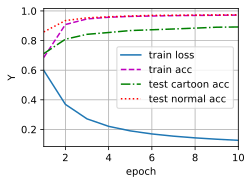

In [7]:
batch_size=32
data_dir = "../data/ch04-4-9-2and4-9-3/dogvscat"
#计算数据平均值和标准差
mean_train_list,std_train_list=getmean_str(os.path.join(data_dir, 'train'),'train')
mean_testcartoon_list,std_testcartoon_list=getmean_str(os.path.join(data_dir, 'testcartoon'),'testcartoon')
mean_testnormal_list,std_testnormal_list=getmean_str(os.path.join(data_dir, 'test'),'testnormal')
#加载数据并标准化
train_iter,image_train_datasets=load_data_cartoonvsnormal(os.path.join(data_dir, 'train'),mean_train_list,std_train_list,batch_size)
testcartoon_iter,image_testcartoon_datasets=load_data_cartoonvsnormal(os.path.join(data_dir, 'testcartoon'),mean_testcartoon_list,std_testcartoon_list,batch_size)
testnormal_iter,image_testnormal_datasets=load_data_cartoonvsnormal(os.path.join(data_dir, 'test'),mean_testnormal_list,std_testnormal_list,batch_size)
#加载模型
model_no_detector = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
Use_gpu = torch.cuda.is_available()#检测是否有GPU

for parma in model_no_detector.parameters():
    parma.requires_grad = False#屏蔽预训练模型的权重，只训练最后一层的全连接的权重
model_no_detector.fc = torch.nn.Linear(2048,2)
nn.init.xavier_uniform_(model_no_detector.fc.weight);


if Use_gpu:
    model_no_detector = model_no_detector.cuda()

#损失函数和优化器
loss_f = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_no_detector.fc.parameters(),lr =  1e-4)

num_epochs = 10
train_ch4_9(model_no_detector, train_iter, testcartoon_iter, loss_f, num_epochs,optimizer,Use_gpu,test_iter2=testnormal_iter,savename='../data/ch04-4-9-2and4-9-3/dogvscatwithoutdetectormodel.pth')
#清除内存
del model_no_detector

torch.cuda.empty_cache()

epoch10 Loss:0.0771 Train Acc:87.7000% Test Cartoon Acc:77.6800% Test Normal Acc:87.9400%
save ../data/ch04-4-9-2and4-9-3/dogvscatwithdetectormodel.pth over


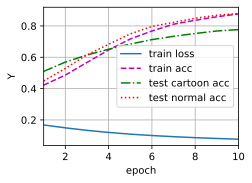

In [8]:
gc.collect()#内存清理
#数据加载
batch_size=32
data_dir = "../data/ch04-4-9-2and4-9-3/dogvscat"
#计算数据平均值和标准差
mean_train_list,std_train_list=getmean_str(os.path.join(data_dir, 'train'),'train')
mean_testcartoon_list,std_testcartoon_list=getmean_str(os.path.join(data_dir, 'testcartoon'),'testcartoon')
mean_testnormal_list,std_testnormal_list=getmean_str(os.path.join(data_dir, 'test'),'testnormal')
#加载数据并标准化
train_iter,image_train_datasets=load_data_cartoonvsnormal(os.path.join(data_dir, 'train'),mean_train_list,std_train_list,batch_size)
testcartoon_iter,image_testcartoon_datasets=load_data_cartoonvsnormal(os.path.join(data_dir, 'testcartoon'),mean_testcartoon_list,std_testcartoon_list,batch_size)
testnormal_iter,image_testnormal_datasets=load_data_cartoonvsnormal(os.path.join(data_dir, 'test'),mean_testnormal_list,std_testnormal_list,batch_size)
#加载模型
model_detector = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
Use_gpu = torch.cuda.is_available()
if Use_gpu:
    torch.cuda.empty_cache()
    print('clear')
for parma in model_detector.parameters():
    parma.requires_grad = False#屏蔽预训练模型的权重，只训练最后一层的全连接的权重
model_detector.fc = torch.nn.Linear(2048,2)
nn.init.xavier_uniform_(model_detector.fc.weight); 


if Use_gpu:
    model_detector = model_detector.cuda()

#损失函数和优化器
def myloss(y_hat,y,beta):
    loss_f = torch.nn.CrossEntropyLoss(reduction='none')
    l=loss_f(y_hat,y)
    return torch.mul(beta,l).mean() 
    
    
optimizer = torch.optim.SGD(model_detector.fc.parameters(),lr =1e-4) 

num_epochs = 10
train_ch4_9(model_detector, train_iter, testcartoon_iter,myloss, num_epochs,optimizer,Use_gpu,test_iter2=testnormal_iter,savename='../data/ch04-4-9-2and4-9-3/dogvscatwithdetectormodel.pth',detector=covariate_shift_detector)
#清除内存
del model_detector
torch.cuda.empty_cache()

epoch10 Loss:0.4791 Train Acc:97.9750% Test Cartoon Acc:90.9000% Test Normal Acc:97.6600%
save ../data/ch04-4-9-2and4-9-3/dogvscatwithdetectormodel.pth over


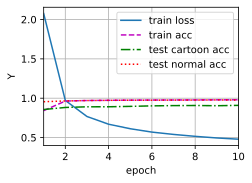

In [9]:
gc.collect()#内存清理
#数据加载
batch_size=32
data_dir = "../data/ch04-4-9-2and4-9-3/dogvscat"
#计算数据平均值和标准差
mean_train_list,std_train_list=getmean_str(os.path.join(data_dir, 'train'),'train')
mean_testcartoon_list,std_testcartoon_list=getmean_str(os.path.join(data_dir, 'testcartoon'),'testcartoon')
mean_testnormal_list,std_testnormal_list=getmean_str(os.path.join(data_dir, 'test'),'testnormal')
#加载数据并标准化
train_iter,image_train_datasets=load_data_cartoonvsnormal(os.path.join(data_dir, 'train'),mean_train_list,std_train_list,batch_size)
testcartoon_iter,image_testcartoon_datasets=load_data_cartoonvsnormal(os.path.join(data_dir, 'testcartoon'),mean_testcartoon_list,std_testcartoon_list,batch_size)
testnormal_iter,image_testnormal_datasets=load_data_cartoonvsnormal(os.path.join(data_dir, 'test'),mean_testnormal_list,std_testnormal_list,batch_size)
#加载模型
model_detector = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
Use_gpu = torch.cuda.is_available()
if Use_gpu:
    #del modelwithoutdetector
    torch.cuda.empty_cache()
    print('clear')
for parma in model_detector.parameters():
    parma.requires_grad = False#屏蔽预训练模型的权重，只训练最后一层的全连接的权重
model_detector.fc = torch.nn.Linear(2048,2)
nn.init.xavier_uniform_(model_detector.fc.weight);  # 对神经网络模型参数进行Xavier均匀分布初始化


if Use_gpu:
    model_detector = model_detector.cuda()

#损失函数和优化器
def myloss(y_hat,y,beta):
    loss_f = torch.nn.CrossEntropyLoss(reduction='none')
    l=loss_f(y_hat,y)
    return 25*torch.mul(beta,l).mean() #直接使用beta计算结果 并没有改善 这可能是因为beta小于1 使loss变小 导致更新梯度以后 变化不大 所以乘以一个数 以改善这种情况
     
    
optimizer = torch.optim.SGD(model_detector.fc.parameters(),lr =1e-4) 

num_epochs = 10
train_ch4_9(model_detector, train_iter, testcartoon_iter,myloss, num_epochs,optimizer,Use_gpu,test_iter2=testnormal_iter,savename='../data/ch04-4-9-2and4-9-3/dogvscatwithdetectormodel.pth',detector=covariate_shift_detector)
#清除内存
del model_detector
torch.cuda.empty_cache()

In [10]:
gc.collect()
Use_gpu = torch.cuda.is_available()
if Use_gpu:
    #del modelwithoutdetector
    torch.cuda.empty_cache()
    print('clear')
data_dir = "../data/ch04-4-9-2and4-9-3/dogvscat"
batch_size=32
mean_testcartoon_list,std_testcartoon_list=getmean_str(os.path.join(data_dir, 'testcartoon'),'testcartoon')
testcartoon_iter,image_testcartoon_datasets=load_data_cartoonvsnormal(os.path.join(data_dir, 'testcartoon'),mean_testcartoon_list,std_testcartoon_list,batch_size)
#加载模型
model_detector = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
model_detector.fc = torch.nn.Linear(2048,2)
model_detector.load_state_dict(torch.load('../data/ch04-4-9-2and4-9-3/dogvscatwithdetectormodel.pth'))
#加载模型没有分类器的模型
model_no_detector = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
model_no_detector.fc = torch.nn.Linear(2048,2)
model_no_detector.load_state_dict(torch.load('../data/ch04-4-9-2and4-9-3/dogvscatwithoutdetectormodel.pth'))
print("没使用分类器测试准确率：{:.4f}%,使用分类器测试准确率：{:.4f}%".format(100*evaluate_accuracy_ch4_9(model_no_detector,testcartoon_iter,Use_gpu),100*evaluate_accuracy_ch4_9(model_detector, testcartoon_iter,Use_gpu)))
#清除内存
del model_no_detector
del model_detector
torch.cuda.empty_cache()

clear
testcartoon  mean: tensor([0.4168, 0.3945, 0.3463]) std: tensor([0.2118, 0.2033, 0.1590])
没使用分类器测试准确率：89.1800%,使用分类器测试准确率：90.9000%


### 练习四

4.除了分布偏移，还有什么会影响经验风险接近真实风险的程度？

&emsp;&emsp;除了分布偏移之外，还有以下因素可能会影响经验风险接近真实风险的程度：

1. 样本大小：经验风险的准确性通常随着样本大小的增加而增加。较大的样本量提供了更多的信息，使得估计的风险更加可靠。
2. 特征选择：选择恰当的特征可以减少噪声和冗余信息的影响，从而提高对真实风险的估计。良好的特征选择有助于提高模型的泛化能力。
3. 模型复杂度：模型的复杂度与其在训练数据上的表现以及对真实风险的估计密切相关。过于简单的模型可能无法捕捉到数据中的复杂关系，而过于复杂的模型可能过度拟合训练数据，导致经验风险与真实风险之间的差距增大。
4. 数据质量：数据质量对于经验风险的准确性至关重要。低质量的数据、含有错误或缺失值的数据可能导致错误的模型训练和风险估计。
5. 样本选择偏差：如果样本选择不恰当或存在偏差，例如采样方式不随机或样本并非代表总体，那么经验风险可能无法准确地估计真实风险。
6. 噪声和异常值：数据中的噪声和异常值可能对经验风险的估计造成干扰。这些异常值可能使模型过度拟合，并导致对真实风险的估计不准确。

&emsp;&emsp;请注意，这些因素的影响程度可能因具体情况而异，取决于数据集和建模方法的特点。